# Summary

A decision tree with max depth equal to 1 is slightly better than the heuristic and the currently deployed model. Thus, a new model will be deployed now. 

# Setup

In [1]:
%config Completer.use_jedi = False

In [2]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

from dataprep import db_to_df

# Data preparation

In [3]:
articles = db_to_df()
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 1 to 44
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   author                          31 non-null     object
 1   title                           44 non-null     object
 2   url                             44 non-null     object
 3   published_at                    44 non-null     object
 4   content                         42 non-null     object
 5   source_name                     44 non-null     object
 6   predicted_score_when_presented  44 non-null     int64 
 7   assigned_score                  44 non-null     int64 
 8   is_test_record                  44 non-null     int64 
dtypes: int64(3), object(6)
memory usage: 3.4+ KB


In [4]:
articles['published_at'] = pd.to_datetime(articles['published_at'])

In [5]:
articles.head()

,author,title,url,published_at,content,source_name,predicted_score_when_presented,assigned_score,is_test_record
id,,,,,,,,,
1,Tyler Sullivan,"2022 NFL Free Agency tracker: Live updates, la...",https://www.cbssports.com/nfl/news/2022-nfl-fr...,2022-03-15 14:35:03+00:00,The dominos are continuing to fall across the ...,CBS Sports,50,-999,0
2,"By <a href=""/profiles/jessie-yeung"">Jessie Yeu...",Russia invades Ukraine: Live updates - CNN,https://www.cnn.com/europe/live-news/ukraine-r...,2022-03-05 06:27:00+00:00,"Russia is poised to deploy up to 1,000 more me...",CNN,50,-999,1
3,"By <a href=""/profiles/jessie-yeung"">Jessie Yeu...",Russia invades Ukraine: Live updates - CNN,https://www.cnn.com/europe/live-news/ukraine-r...,2022-03-05 06:27:00+00:00,"Russia is poised to deploy up to 1,000 more me...",CNN,50,95,0
4,None,Apple presses U.S. lawmakers on dangers of 'si...,https://www.reuters.com/technology/apple-press...,2022-03-04 22:13:00+00:00,"WASHINGTON, March 4 (Reuters) - Smartphone mak...",Reuters,50,50,1
5,Brent Sobleski,Top 5 Potential Landing Spots for Dallas Cowbo...,https://bleacherreport.com/articles/2954024-to...,2022-03-04 22:34:10+00:00,Ron Schwane/Associated Press\r\nMuch like Coop...,Bleacher Report,50,0,0


In [6]:
# drop dummy records

n_rows_bef = len(articles)
articles = articles[articles['assigned_score']!=-999]
n_rows_after = len(articles)
print(f'{n_rows_bef - n_rows_after} rows dropped.')

2 rows dropped.


In [7]:
# drop duplicates

n_rows_bef = len(articles)
articles = articles.drop_duplicates(subset=['title', 'published_at'])
n_rows_after = len(articles)
print(f'{n_rows_bef - n_rows_after} rows dropped.')

0 rows dropped.


In [8]:
training = articles[articles['is_test_record']==0]
test = articles[articles['is_test_record']==1]

print(f'Number of training records: {len(training)}')
print(f'Number of test records: {len(test)}')

Number of training records: 21
Number of test records: 21


# EDA

<AxesSubplot:xlabel='assigned_score', ylabel='Count'>

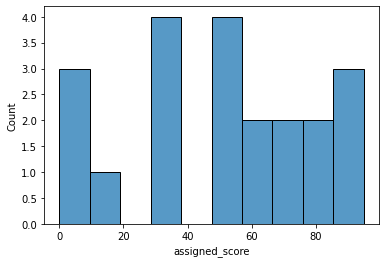

In [9]:
sns.histplot(training['assigned_score'], bins=10)
# assigned score is the target value assigned by the user

Some value ranges in the training set are missing which is to be expected by such a small dataset.

# Modeling

In [10]:
y_train = training['assigned_score']
y_test = test['assigned_score']

In [11]:
seed = 23

## Baseline model

In [12]:
class BaselineModel:
    
    def train(self, y_train):
        self.mean_y = y_train.mean()
        
    def predict(self, x):
        n_preds = len(x)
        return np.full(n_preds, self.mean_y)

In [13]:
model = BaselineModel()
model.train(y_train)
y_pred = model.predict(test)

bl_mae = mean_absolute_error(y_pred, y_test)
print(f'MAE for the baseline model : {round(bl_mae, 2)}')

MAE for the baseline model : 27.75


## Current model

In [14]:
feature_cols = ['author', 'source_name']

In [15]:
x_test = test[feature_cols]

encoder = pickle.load(open('source_encoder.pkl', 'rb'))
x_test = encoder.transform(x_test)

In [16]:
model = pickle.load(open('ml_model.pkl', 'rb'))
y_pred = model.predict(x_test)

cur_mae = mean_absolute_error(y_pred, y_test)
print(f'MAE for the model currently in production: {round(cur_mae, 2)}')

MAE for the model currently in production: 27.67


## Current model - retrained

In [17]:
x_train = training[feature_cols]
x_test = test[feature_cols]

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)
encoder.fit(x_train)

x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

In [18]:
model = DecisionTreeRegressor(random_state=seed)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

rt_mae = mean_absolute_error(y_pred, y_test)
print(f'MAE for the retrained model: {round(rt_mae, 2)}')

MAE for the retrained model: 36.52


In [19]:
y_pred = model.predict(x_train)
rt_mae_train = mean_absolute_error(y_pred, y_train)
print(f'Training set MAE for the retrained model: {round(rt_mae_train, 2)}')

Training set MAE for the retrained model: 2.33


This is a clear example of overfitting. Changing the max_depth is exactly what should help with this problem.

## New max_depth value

In [20]:
x_train = training[feature_cols]
x_test = test[feature_cols]

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)
encoder.fit(x_train)

x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

In [21]:
params = {
    'max_depth': (1, 2, 3, 4, 5, None)
}

model = DecisionTreeRegressor(random_state=seed)
grid = GridSearchCV(model, params, scoring='neg_mean_absolute_error')
grid.fit(x_train, y_train)
results = pd.DataFrame(grid.cv_results_)

In [22]:
grid.best_params_

{'max_depth': 1}

In [23]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000496,0.000314,0.000198,0.000243,1,{'max_depth': 1},-26.760000,-12.750000,-39.656250,-27.59375,-23.250000,-26.002000,8.634070,1
1,0.000397,0.000198,0.000198,0.000243,2,{'max_depth': 2},-32.520000,-25.000000,-36.227273,-32.55000,-40.583333,-33.376121,5.131234,2
2,0.000198,0.000243,0.000297,0.000243,3,{'max_depth': 3},-42.910000,-36.416667,-37.544643,-32.13750,-41.500000,-38.101762,3.831175,6
3,0.000298,0.000243,0.000198,0.000243,4,{'max_depth': 4},-46.266667,-26.250000,-52.354167,-14.50000,-49.921429,-37.858452,14.877585,5
4,0.000397,0.000198,0.000198,0.000243,5,{'max_depth': 5},-37.800000,-31.500000,-50.337500,-14.50000,-48.458333,-36.519167,13.001279,3
5,0.000397,0.000198,0.000198,0.000243,None,{'max_depth': None},-38.600000,-32.000000,-48.437500,-14.50000,-53.000000,-37.307500,13.565792,4


The mean MAE for the best parameter is 26. It's slighlty better than the heuristic and the model currently in production.